In [7]:
# Base packages
from torch.utils.data import Dataset
import torch
from torch.utils.data import DataLoader

# Defined packages
from inputs import RandomPattern
from neuralBehaviors import *
from synapseBehaviors import *
from metrics import draw_weights

# PyMonnTorch and CoNeX
from pymonntorch import NeuronGroup, SynapseGroup, NeuronDimension, EventRecorder, Recorder

from conex import Neocortex, InputLayer, Synapsis, prioritize_behaviors, CorticalColumn
from conex.behaviors.synapses import SynapseInit, WeightInitializer, LateralDendriticInput, SimpleDendriticInput, WeightNormalization
from conex.behaviors.synapses.learning import SimpleSTDP
from conex.behaviors.neurons.axon import NeuronAxon
from conex.behaviors.neurons.specs import SpikeTrace, Fire, KWTA
from conex.behaviors.neurons.dendrite import SimpleDendriteStructure, SimpleDendriteComputation
from conex.behaviors.neurons.neuron_types.lif_neurons import LIF, ELIF




SIZE = 10
TIME = 30
NORM = 10
dataset = RandomPattern(
    pattern1=[1, 1, 0, 1, 1, 0, 0, 0, 0, 0],
    pattern2=[0, 0, 0, 0, 0, 1, 1, 0, 1, 1],
    period=10,
)


net = Neocortex(dt=1)

input_layer = NeuronGroup(size=SIZE, net=net, behavior={
    **prioritize_behaviors([
        LIF(R=100, threshold=-50, tau=1, v_reset=-75, v_rest=-65),
        Fire(), 
        SpikeTrace(tau_s=0.9),
        NeuronAxon(), 
        ]),
    160: ResetIBehavior(),
    170: InputBehavior(dataset),
    500: EventRecorder(variables=['spikes']),
})

out_ng = NeuronGroup(net=net, size=2, tag='out', behavior={**prioritize_behaviors(
    [
        SimpleDendriteStructure(),
        SimpleDendriteComputation(),
        ELIF(R=50, threshold=-50, tau=1, v_reset=-75, v_rest=-65, delta=2, theta_rh=0),
        KWTA(k=1),
        Fire(),
        SpikeTrace(tau_s=0.9),
        NeuronAxon(),
        
    ]),
    # 160: ResetIBehavior(),
    180: LateralInhibition(alpha=100),
    341: Recorder(variables=['v']), # right after Fire
    500: EventRecorder(variables=['spikes']),
    })
synapsis_input_out = SynapseGroup(net=net, src=input_layer, dst=out_ng, behavior={
                                    **prioritize_behaviors(
                                      [
                                        SynapseInit(), 
                                        SimpleDendriticInput(),
                                        WeightInitializer(mode='random', weight_shape=(10, 2), scale=1 + NORM // SIZE), 
                                        WeightNormalization(norm=NORM),
                                        SimpleSTDP(a_plus=1, a_minus=0),
                                      ]),}
                                    , tag="Proximal")



net.initialize(info=False)
oldW = synapsis_input_out.weights.clone()
net.simulate_iterations(1000, measure_block_time=False)
newW = synapsis_input_out.weights.clone()

print(f"\nDiff W = \n{newW - oldW}")

print(f"input layer spikes: {input_layer['spikes'][0].shape[0]}")
print(f"out layer spikes: {out_ng['spikes'][0].shape[0] if out_ng['spikes'] else 0}")

print(f"Weights:\n{synapsis_input_out.weights}")




Diff W = 
tensor([[-1.7205,  1.8852],
        [-2.0289, -0.9600],
        [ 3.6486,  3.9661],
        [ 0.9794, -1.9204],
        [-0.5486, -3.1164],
        [-1.4757,  0.4681],
        [-0.6510,  2.2474],
        [ 3.3008,  4.0586],
        [-0.2177, -3.6921],
        [-1.2864, -2.9364]])
input layer spikes: 4000
out layer spikes: 72
Weights:
tensor([[-1.3754,  3.5325],
        [-1.8282,  0.1210],
        [ 5.3566,  4.7556],
        [ 2.5884, -1.0306],
        [ 0.3451, -2.4647],
        [-0.8169,  1.7892],
        [ 0.3937,  3.9226],
        [ 4.8459,  4.8664],
        [ 1.0299, -3.1991],
        [-0.5391, -2.2930]])


In [8]:
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(1, 1, figsize=(10, 5))

print(out_ng['spikes'][0].shape)


torch.Size([72, 2])


Patterns:
	1: tensor([1, 1, 0, 1, 1, 0, 0, 0, 0, 0])
	2:tensor([0, 0, 0, 0, 0, 1, 1, 0, 1, 1])
tensor([[0.3451, 1.6473],
        [0.2007, 1.0810],
        [1.7080, 0.7895],
        [1.6090, 0.8898],
        [0.8937, 0.6517],
        [0.6587, 1.3211],
        [1.0447, 1.6753],
        [1.5452, 0.8079],
        [1.2476, 0.4930],
        [0.7473, 0.6434]])
tensor([10., 10.])
tensor([[-1.3754,  3.5325],
        [-1.8282,  0.1210],
        [ 5.3566,  4.7556],
        [ 2.5884, -1.0306],
        [ 0.3451, -2.4647],
        [-0.8169,  1.7892],
        [ 0.3937,  3.9226],
        [ 4.8459,  4.8664],
        [ 1.0299, -3.1991],
        [-0.5391, -2.2930]])
tensor([10., 10.])


Sim = 0.6006448864936829


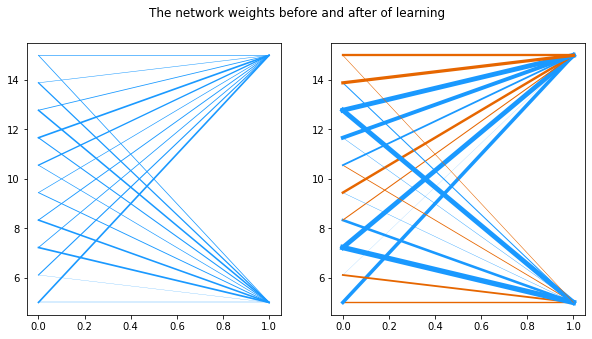

In [9]:
import matplotlib.pyplot as plt
print(f"Patterns:\n\t1: {dataset.pats[0]}\n\t2:{dataset.pats[1]}")

print(oldW)
print(oldW.sum(0))
print(newW)
print(newW.sum(0))
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
draw_weights(weights=oldW, ax=ax[0], scale_w=1)
draw_weights(weights=newW, ax=ax[1], scale_w=1)
plt.suptitle("The network weights before and after of learning")

from torch.nn.functional import cosine_similarity
sim = cosine_similarity(oldW.flatten(), newW.flatten(), dim=0)
print(f"Sim = {sim}")
plt.show()


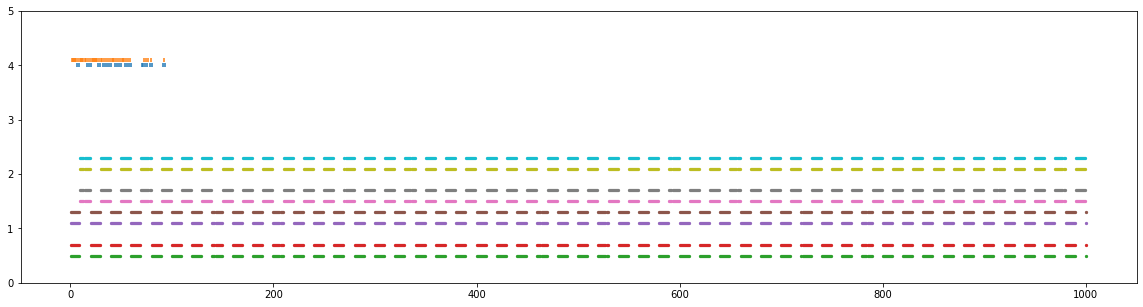

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(20, 5))


spikes = out_ng['spikes'][0]
zeros = out_ng['spikes'][0][:, 1] == 0
firsts = spikes[zeros]
seconds = spikes[~zeros]
ax.scatter(x=out_ng['spikes', 0][zeros][:, 0], y=4 * torch.ones(zeros.sum()), marker='|', s=20)
ax.scatter(x=out_ng['spikes', 0][~zeros][:, 0], y=4.1 * torch.ones((~zeros).sum()), marker='|', s=20)


spikes = input_layer['spikes'][0]
for i in input_layer['spikes'][0][:, 1].unique():
    times = input_layer['spikes'][0][:, 1] == i
    ax.scatter(x=spikes[times][:, 0], y=0.5 + 0.2 * i * torch.ones(times.sum()), marker='.', s=20)
    
ax.set_ylim(0, 5)
plt.show()



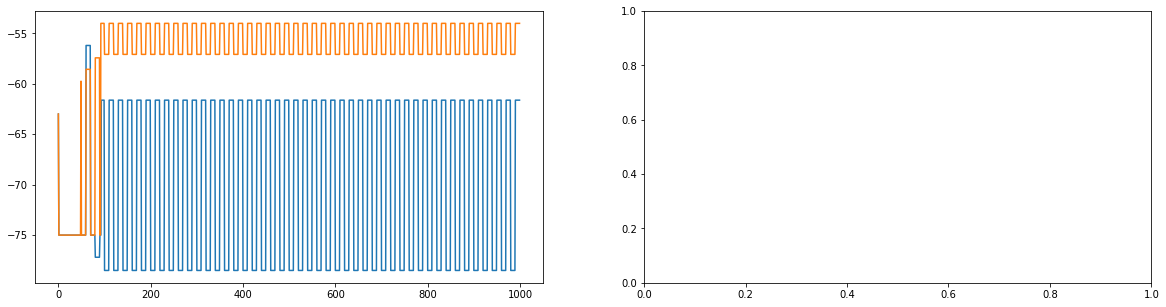

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
v = out_ng['v'][0]
ax[0].plot(v[:, 0])
ax[0].plot(v[:, 1])
plt.show()
